# analyze_escape_data.ipynb
### Script to read in filtered antibody escape data, analyze, make logo plots, make altair figures for paper.
- Written by Brendan Larsen

In [1]:
# this cell is tagged as parameters for `papermill` parameterization
#configs
altair_config = None
nipah_config = None
#inputs
binding_data = None
HENV103_filter = None
HENV117_filter = None
HENV26_filter = None
HENV32_filter = None
m102_filter = None
nAH1_filter = None
func_scores_low_effect_E3_file = None
concat_df_file = None
#outputs
escape_bubble_plot = None
bubble_1_mut_plot = None
mab_line_escape_plot = None
aggregate_mab_and_binding = None
aggregate_mab_and_niv_polymorphism = None
mab_plot_top = None
mab_plot_all = None
combined_evol_sites_escape = None

In [2]:
import math
import os
import re
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats
import Bio.SeqIO
import yaml
import matplotlib

matplotlib.rcParams["svg.fonttype"] = "none"

from Bio import PDB
import dmslogo
from dmslogo.colorschemes import CBPALETTE
from dmslogo.colorschemes import ValueToColorMap
import sys

# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

# setup working directory
if os.getcwd() == "/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/":
    pass
    print("Already in correct directory")
else:
    os.chdir("/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/")
    print("Setup in correct directory")

#import altair themes from /data/custom_analyses_data/theme.py and enable
sys.path.append('data/custom_analyses_data/')
import theme
alt.themes.register('main_theme', theme.main_theme)
alt.themes.enable('main_theme')

Setup in correct directory


ThemeRegistry.enable('main_theme')

### For running interactively

In [3]:
if nipah_config is None:
    print("this notebook is being run manually")
    #configs
    #altair_config = "data/custom_analyses_data/theme.py"
    nipah_config = "nipah_config.yaml"
    #input
    HENV103_filter = "results/filtered_data/escape/HENV103_escape_filtered.csv"
    HENV117_filter = "results/filtered_data/escape/HENV117_escape_filtered.csv"
    HENV26_filter = "results/filtered_data/escape/HENV26_escape_filtered.csv"
    HENV32_filter = "results/filtered_data/escape/HENV32_escape_filtered.csv"
    m102_filter = "results/filtered_data/escape/m102_escape_filtered.csv"
    nAH1_filter = "results/filtered_data/escape/nAH1_escape_filtered.csv"

    func_scores_low_effect_E3_file = "results/filtered_data/escape/e3_low_mab_effect_filter.csv"
    concat_df_file = "results/filtered_data/escape/mab_filter_concat.csv"
    binding_data = "results/filtered_data/binding/e2_binding_filtered.csv"
else:
    print("this notebook was run automatically")

this notebook is being run manually


### Load config files

In [4]:
with open(nipah_config) as f:
    config = yaml.safe_load(f)

# Load data

In [5]:
func_scores_E3_low_effect = pd.read_csv(func_scores_low_effect_E3_file) # read low effect cell entry data for making heatmaps
combined_df = pd.read_csv(concat_df_file) # read filtered concatanated antibody escape data
bind_df = pd.read_csv(binding_data) # read filtered ephrin-b2 binding data

### Find the top escape sites and make lists for different antibody subsets

In [7]:
def find_top_sites(df,ab):
    tmp_df = df[df['ab'] == ab] #filter
    top_escape_df = tmp_df.query('top_escape == True')    #find max escape sites
    #top_escape_df.loc[top_escape_df['escape_mean'] < 0.25, 'escape_mean'] = 0

    sum_site_list = top_escape_df['site'].unique().tolist()
    print(sum_site_list)
    return sum_site_list

#call the function and make site list for each mAb
m102_sites = find_top_sites(combined_df,'m102.4')
HENV26_sites = find_top_sites(combined_df,'HENV-26')
HENV117_sites = find_top_sites(combined_df,'HENV-117')
HENV103_sites = find_top_sites(combined_df,'HENV-103')
HENV32_sites = find_top_sites(combined_df,'HENV-32')
nAH1_sites = find_top_sites(combined_df,'nAH1.3')

#make combined lists of antibodies depending on epitope
binding_face_list = list(set(m102_sites + HENV26_sites + HENV117_sites))
dimer_face_list = list(set(HENV103_sites + HENV32_sites))
everything_list = list(set(m102_sites + HENV26_sites + HENV117_sites + HENV103_sites + HENV32_sites + nAH1_sites))

[239, 507, 559, 577, 582, 586, 589]
[491, 494, 501, 530]
[171, 258, 555, 580, 582, 583, 586, 587]
[205, 258, 259, 260, 264]
[199, 200, 205]
[184, 185, 186, 187, 188, 189, 190, 447, 448, 449, 450, 451, 452, 468, 513, 515, 516, 517, 518, 519, 520, 597]


### make dataframes for making logo plots

In [8]:
def find_sites_for_ab(df,site_list,ab_list,color_by):    
    tmp_df = combined_df[combined_df['site'].isin(site_list)]
    tmp_df = tmp_df[tmp_df['ab'].isin(ab_list)]
    #Add wildtype residue info for logo plot
    tmp_df['wildtype_site'] = tmp_df['wildtype'].astype(str) + tmp_df['site'].astype(str)
    #Find colors based on effect
    tmp_df['clip'] = np.clip(tmp_df[color_by], None, 0)
    min_prop = tmp_df[color_by].min()
    max_prop = tmp_df['clip'].max()
    map1 = ValueToColorMap(minvalue=(min_prop-0.5), maxvalue=max_prop, cmap='YlGn')
    tmp_df['color'] = tmp_df['clip'].map(map1.val_to_color)
    return tmp_df

# get information for binding face antibodies
binding_face_df = find_sites_for_ab(combined_df,binding_face_list,['m102.4','HENV-26','HENV-117'],'effect')

#Want to put them in a specific order so do the following:
custom_order = ['m102.4', 'HENV-117', 'HENV-26']
binding_face_df['ab'] = pd.Categorical(binding_face_df['ab'], categories=custom_order, ordered=True)
binding_face_df = binding_face_df.sort_values(by='ab')

# get dimer face information
dimer_face_df = find_sites_for_ab(combined_df,dimer_face_list,['HENV-103','HENV-32'],'effect')
# get information about nAH1.3
nAH1_df = find_sites_for_ab(combined_df,nAH1_sites,['nAH1.3'],'effect')

#make a df for sites that have opposite effects on mab escape
custom_order=['m102.4', 'HENV-117', 'HENV-26','HENV-103','HENV-32']
fusion_trig_df = find_sites_for_ab(combined_df,[165,166,167,168,169,170,171,172,204,208,209,270,589],['m102.4','HENV-117','HENV-26','HENV-32','HENV-103'],'effect')
fusion_trig_df['ab'] = pd.Categorical(fusion_trig_df['ab'], categories=custom_order, ordered=True)
fusion_trig_df = fusion_trig_df.sort_values(by='ab')

### Make the faceted logo plots

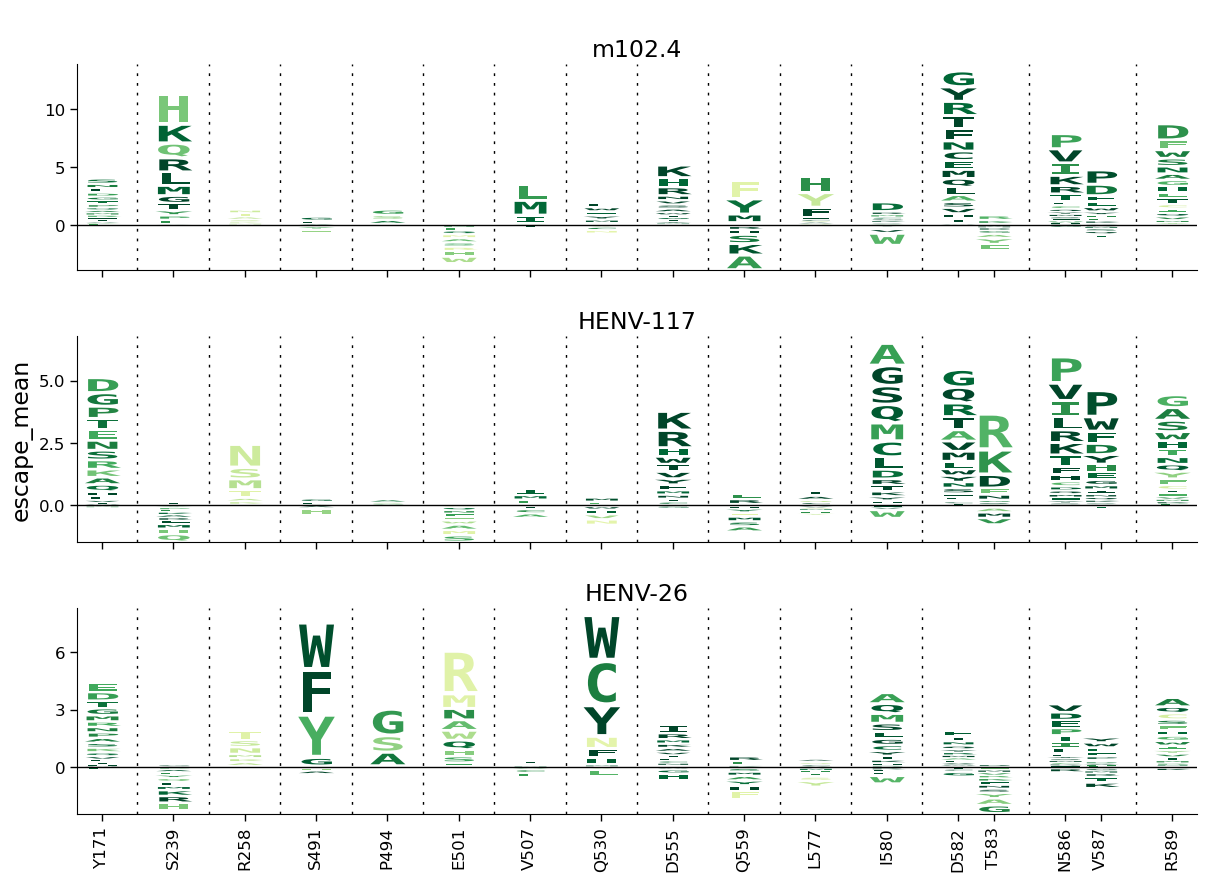

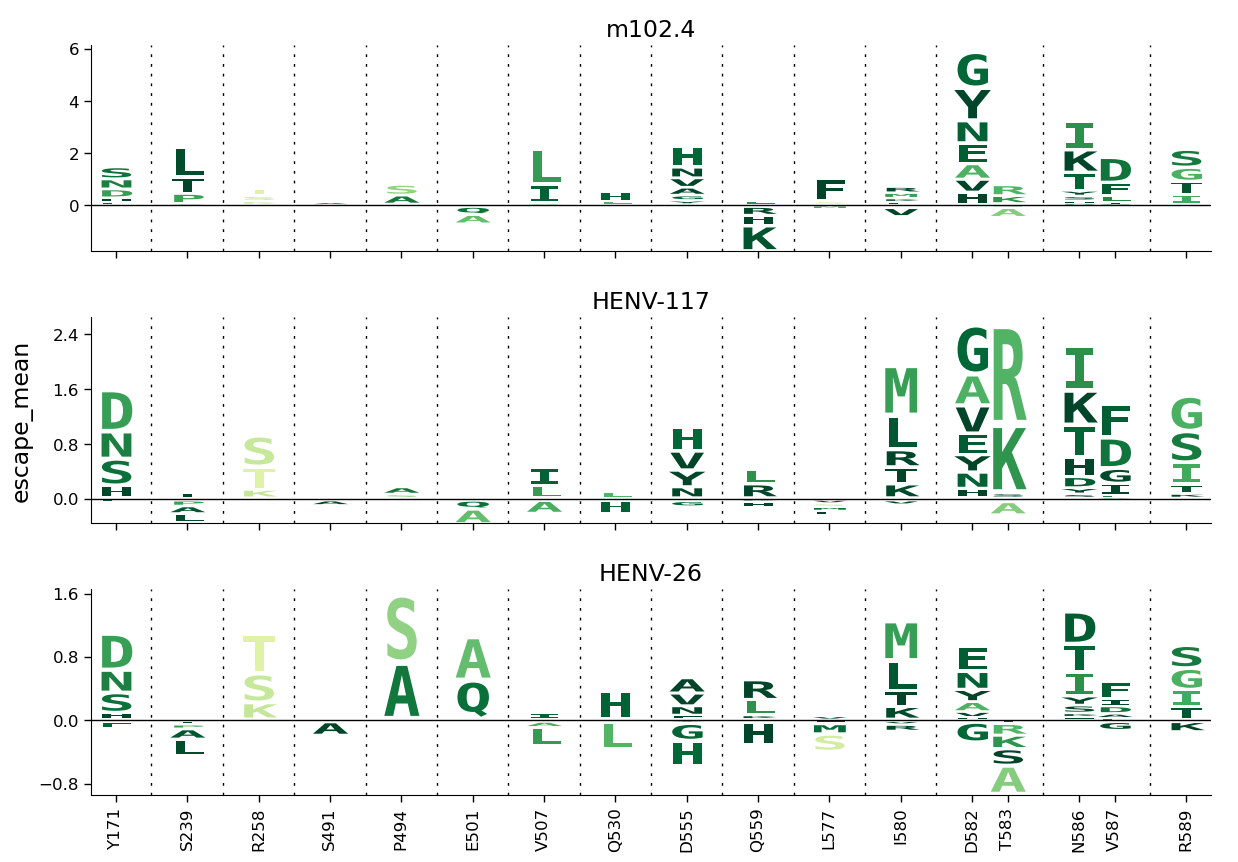

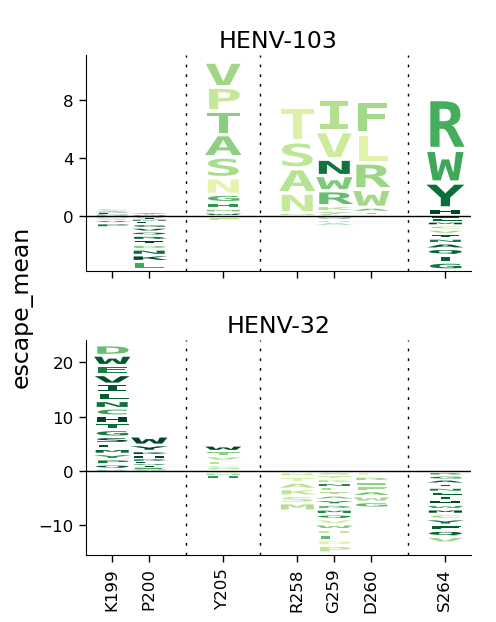

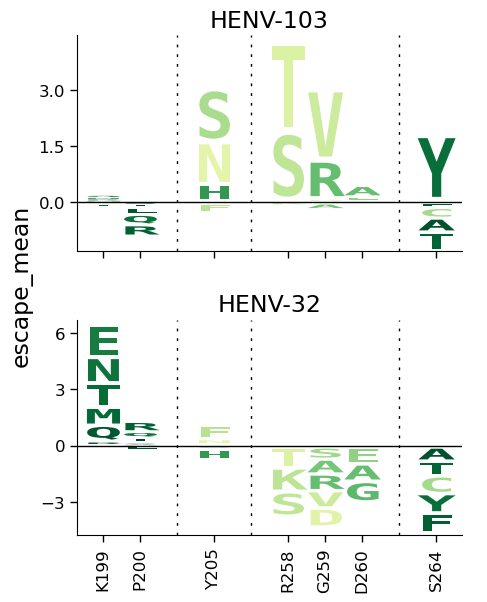

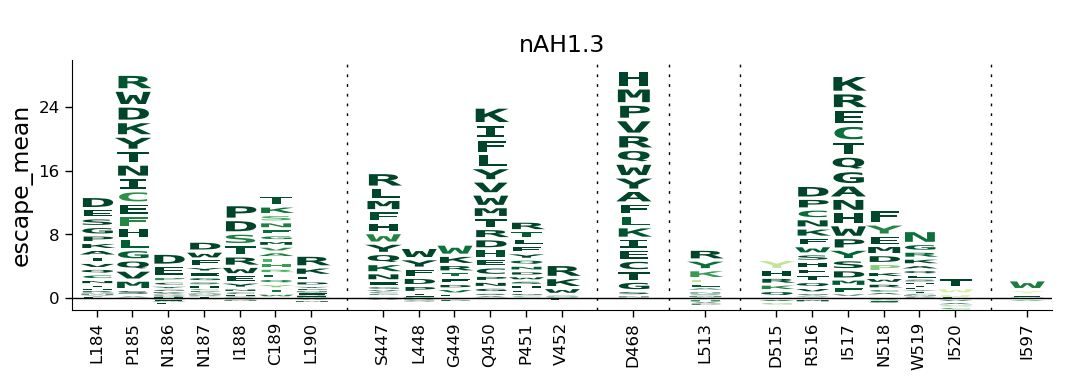

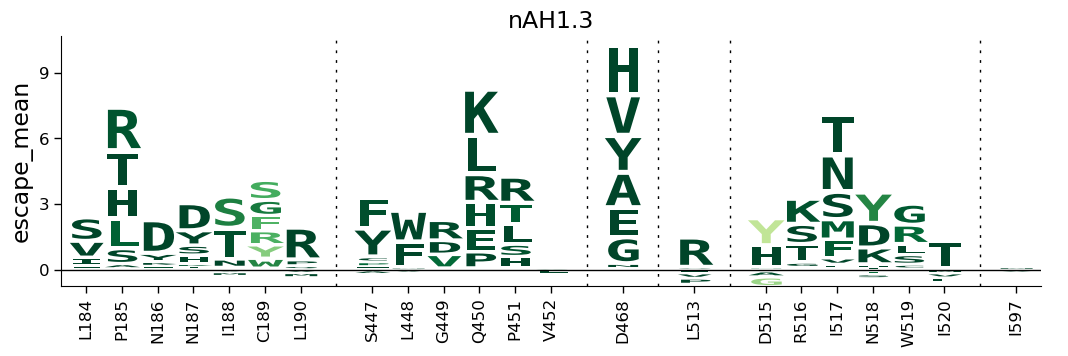

In [11]:
def generate_facet_logo_plot(df,output_file_name):
    """Generate logo plot and save as a file."""
    draw_logo_kwargs={
        "letter_col": "mutant",
        "color_col": "color",
        "xtick_col": "wildtype_site",
        "letter_height_col": "escape_mean",
        "xlabel": "",
        "clip_negative_heights": False,
    }
    fig, ax = dmslogo.facet_plot(
        data=df,
        x_col='site',
        gridrow_col='ab',
        share_ylim_across_rows=False,
        show_col=None,
        draw_logo_kwargs=draw_logo_kwargs,
    )
    fig
    fig.savefig(output_file_name, bbox_inches='tight',format='svg')


# Call functions and save logo plots
generate_facet_logo_plot(binding_face_df,'results/images/logo_plots/binding_face_escape.svg')
generate_facet_logo_plot(binding_face_df.query('min_mutations == 1'),'results/images/logo_plots/binding_face_escape_1_mutant_away.svg')

generate_facet_logo_plot(dimer_face_df,'results/images/logo_plots/dimer_face_escape.svg')
generate_facet_logo_plot(dimer_face_df.query('min_mutations ==1'),'results/images/logo_plots/dimer_face_escape_1_mutant_away.svg')

generate_facet_logo_plot(nAH1_df,'results/images/logo_plots/nAH1_escape_solo.svg')
generate_facet_logo_plot(nAH1_df.query('min_mutations ==1'),'results/images/logo_plots/nAH1_escape_solo_1_mutant_away.svg')

### Generate a logo plot specifically for opposing muts between receptor binding face and dimerization face

In [ ]:
def generate_facet_logo_plot_binding(df,output_file_name):
    """Generate logo plot and save as a file."""
    draw_logo_kwargs={
        "letter_col": "mutant",
        "color_col": "color",
        "xtick_col": "wildtype_site",
        "letter_height_col": "escape_mean",
        "xlabel": "",
        "clip_negative_heights": False,
    }
    fig, ax = dmslogo.facet_plot(
        data=df,
        x_col='site',
        gridrow_col='ab',
        share_ylim_across_rows=False,
        show_col=None,
        draw_logo_kwargs=draw_logo_kwargs,
    )
    fig
    fig.savefig(output_file_name, bbox_inches='tight',format='svg')
    
generate_facet_logo_plot_binding(fusion_trig_df,'results/images/logo_plots/fusion_trig.svg')

### Find the top sites of escape

In [ ]:
def find_combined_sites(list1, list2):
    # function to find unique elements in two lists and return one sorted list
    combined_list = list(list1) + list(list2)
    unique_elements = set(combined_list)
    sorted_list = sorted(unique_elements)
    return sorted_list


def find_top_mean_escape_sites(df):
    # function to find the top sites of escape for each antibody
    for ab in ['m102.4','HENV-26','HENV-117','HENV-103','HENV-32','nAH1.3']:
        # select specific antibody
        tmp_df = df[df['ab'] == ab]
        # find max escape sites
        tmp_df = tmp_df.groupby(['site'])['escape_mean'].mean().reset_index()
        max_df = tmp_df.sort_values(by='escape_mean',ascending=False).head(10)
        max_sites = list(max_df['site'].unique())
        print(f'For {ab}, top averaged escape sites are :{max_sites}')

        # find top summed escape sites
        agg_df = tmp_df.groupby(['site'])['escape_mean'].sum().reset_index()
        tmp_df_sort = agg_df.sort_values(by='escape_mean',ascending=False).head(10)
        summed_sites = list(tmp_df_sort['site'].unique())
        print(f'For {ab}, top summed escape sites are: {summed_sites}')

        # call function to return unique sorted list
        combined_list = find_combined_sites(max_sites,summed_sites)
        print(f'The combined list for {ab} is: {combined_list}\n')
    
# Call function
find_top_mean_escape_sites(combined_df)

### Make a dictionary of top sites of escape for plotting later

In [ ]:
def identify_escape_sites(df, ab):
    subset = df[(df["ab"] == ab)]
    unique_sites = list(subset["site"].unique())
    return unique_sites


abs = ["HENV-26", "HENV-103", "HENV-32", "HENV-117", "m102.4", "nAH1.3"]
sites_dict = {}  # Create an empty dictionary to store the results

for ab in abs:
    sites_dict[ab] = identify_escape_sites(combined_df.query('top_escape == True'), ab)

# sites_dict is a dictionary with the top sites of escape

### Plot bubble chart showing mAb escape for individual mutants by functional score for both E2 or E3

In [ ]:
order_ab = ["m102.4", "HENV-26", "HENV-117", "HENV-103", "HENV-32", "nAH1.3"]


def generate_bubble_chart(df):
    variant_selector = alt.selection_point(
        on="mouseover", empty=False, fields=["site"], value=1
    )
    chart = (
        alt.Chart(
            df,
            title=alt.Title(
                "Top Antibody Escape Mutations",
                subtitle="Hover over points to see escape at same site",
            ),
        )
        .mark_point(stroke="black",filled=True)
        .encode(
            x=alt.X(
                "ab:O",
                sort=order_ab,
                title="Antibody",
                axis=alt.Axis(labelAngle=-90, grid=False),
            ),
            y=alt.Y(
                "effect:Q",
                title="Cell Entry of Top Escape",
                axis=alt.Axis(
                    grid=True, tickCount=4, values=[0.5, 0, -0.5, -1, -1.5, -2]
                ),
            ),
            size=alt.Size(
                "escape_mean", legend=alt.Legend(title="Mean Escape By Mutation")
            ),
            xOffset="random:Q",
            tooltip=[
                "site",
                "wildtype",
                "mutant",
                "ab",
                "effect",
                "escape_mean",
                "escape_std",
            ],
            color=alt.Color("ab").legend(None),
            opacity=alt.condition(variant_selector, alt.value(1), alt.value(0.2)),
            strokeWidth=alt.condition(variant_selector, alt.value(2), alt.value(0)),
        )
        .transform_calculate(
            random="sqrt(-1*log(random()))*cos(2*PI*random())"
        )
        .properties(width=config["bubble_width"], height=config["bubble_height"])
        .add_params(variant_selector)
    )

    return chart


escape_bubble = generate_bubble_chart(combined_df.query('top_escape == True & escape_mean > 0'))
escape_bubble.display()
if mab_line_escape_plot is not None:
    escape_bubble.save(escape_bubble_plot)

### Make heatmap of overlapping escape sites between two antibodies

In [ ]:
def find_overlapping_escape(df):
    slider = alt.binding_range(
        min=config["min_func_effect_for_ab"], max=0, step=0.25, name="effect"
    )
    selector = alt.param(name="SelectorName", value=-4, bind=slider)

    radio = alt.binding_radio(options=[1, 2, 3], name="Min Mutations:")
    mutation_selector = alt.param(name="MutationSelector", value=1, bind=radio)

    df_filtered = df
    # Group by 'site' and 'mutant', count the unique 'ab' values for each group
    grouped = df_filtered.groupby(["site", "mutant"])["ab"].nunique().reset_index()

    # Filter groups where the count of unique 'ab' values is at least 2
    result = grouped[grouped["ab"] >= 2]

    # Merge the result with the original dataframe to get the full rows
    df_result = pd.merge(df, result[["site", "mutant"]], on=["site", "mutant"])
    df_result["mutation_number"] = (
        df_result["mutation"].str.extract("(\d+)").astype(int)
    )
    base = (
        (
            alt.Chart(df_result, title=alt.Title("Shared antibody escape mutations"))
            .mark_rect()
            .encode(
                x=alt.X(
                    "mutation:O",
                    title="Site",
                    sort=alt.EncodingSortField(field="mutation_number"),
                    axis=alt.Axis(labelAngle=-90, grid=False),
                ),
                y=alt.Y(
                    "ab:O", title="Mutant", sort=order_ab, axis=alt.Axis(grid=False)
                ),  # Apply custom sort order here
                color="escape_mean",
                tooltip=[
                    "site",
                    "wildtype",
                    "mutant",
                    "escape_mean",
                    "min_mutations",
                ],
            )
        )
        .properties(height=200, width=400)
        .add_params(selector, mutation_selector)
        .transform_filter(
            (alt.datum.effect >= selector)
            & (alt.datum.min_mutations == mutation_selector)
        )
    )
    return base


overlap_escape = find_overlapping_escape(combined_df.query('top_escape == True'))
overlap_escape.display()
if mab_line_escape_plot is not None:
    overlap_escape.save(overlap_escape_plot)

### Make plot of mean escape by site

In [ ]:
def plot_line_escape(df):
    #Setup interactivity
    variant_selector = alt.selection_point(
        on="mouseover", empty=False,nearest=True, fields=["site"], value=0
    )
    # Group by 'site' and 'mutant', count the unique 'ab' values for each group
    summed = df.groupby(["site", "ab"])["escape_mean"].mean().reset_index().round(3)
    
    # Need to add dummy row because site 500 has been completely masked out due to low entry scores and not showing up on x-axis
    new_row = pd.DataFrame({'site': [500], 'ab': ['HENV-103'], 'escape_mean': [0]})
    summed = pd.concat([summed, new_row], ignore_index=True)
    
    empty_chart = [] # empty list for storing charts
    ab_list = ["m102.4", "HENV-117", "HENV-26", "HENV-103", "HENV-32", "nAH1.3"]
    for idx, ab in enumerate(ab_list):
        tmp_df = summed[summed["ab"] == ab]
        if ab in ["m102.4", "HENV-26", "HENV-117"]:
            color = "#1f4e79"
        if ab in ["HENV-103", "HENV-32"]:
            color = "#ff7f0e"
        if ab in ["nAH1.3"]:
            color = "#2ca02c"

        # Conditionally set the x-axis labels and title for the last plot
        is_last_plot = idx == len(ab_list) - 1
        x_axis = alt.Axis(
            values=[100, 200, 300, 400, 500, 600],
            tickCount=6,
            labelAngle=-90,
            grid=True,
            labelExpr="datum.value % 100 === 0 ? datum.value : ''",
            title="Site" if is_last_plot else None,
            labels=is_last_plot,
        )  # Only show labels for the last plot
        base = (
            alt.Chart(tmp_df)
            .mark_line(size=1, color=color)
            .encode(
                x=alt.X("site:O", axis=x_axis),
                y=alt.Y("escape_mean", title=f"{ab}", axis=alt.Axis(grid=False,tickCount=3)),
            )
            .properties(
                width=800, height=100
            )
        )
        point = (
            base.mark_point(color="black", size=10, filled=True)
            .encode(
                x=alt.X("site:O", axis=x_axis),
                y=alt.Y(
                    "escape_mean",
                    title=f"{ab}",
                    axis=alt.Axis(
                        grid=False,
                    ),
                ),
                size=alt.condition(variant_selector, alt.value(100), alt.value(15)),
                color=alt.condition(
                    variant_selector, alt.value("black"), alt.value(color)
                ),
                tooltip=["site", "escape_mean"],
            )
            .add_params(variant_selector)
        )
        chart = base + point
        empty_chart.append(chart)

    # Use configure_concat to adjust spacing between vertically concatenated plots
    combined_chart = (
        alt.vconcat(*empty_chart, spacing=1)
        .resolve_scale(y="independent", x="shared", color="independent")
        .properties(
            title=alt.Title(
                "Mean Antibody Escape by Site", subtitle="Colored by epitope"
            )
        )
    )

    return combined_chart


tmp_line = plot_line_escape(combined_df.query('escape_mean > 0'))
tmp_line.display()
if mab_line_escape_plot is not None:
    tmp_line.save(mab_line_escape_plot)

### Now calculate atomic distances between escape sites and closest amino acid in heavy and light chains

In [ ]:
def calculate_min_distances(pdb_path, source_chain_id, target_chain_ids, name):
    # Initialize the PDB parser and load the structure
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("structure_id", pdb_path)

    source_chain = structure[0][source_chain_id]
    target_chains = [structure[0][chain_id] for chain_id in target_chain_ids]

    data = []

    for residueA in source_chain:
        if residueA.resname in ["HOH", "WAT", "IPA", "NAG"]:
            continue

        min_distance = float("inf")
        closest_residueB = None
        closest_chain_id = None
        residues_within_4 = 0

        for target_chain in target_chains:
            for residueB in target_chain:
                if residueB.resname in ["HOH", "WAT", "IPA"]:
                    continue

                # Check for residues within 4 angstroms
                is_within_4 = False
                for atomA in residueA:
                    for atomB in residueB:
                        distance = atomA - atomB
                        if distance < min_distance:
                            min_distance = distance
                            closest_residueB = residueB
                            closest_chain_id = target_chain.get_id()
                        if distance < 4:
                            is_within_4 = True
                if is_within_4:
                    residues_within_4 += 1

        data.append(
            {
                "wildtype": residueA.resname,
                "site": residueA.id[1],
                "chain": closest_chain_id,
                "residue": closest_residueB.id[1],
                "residue_name": closest_residueB.resname,
                "distance": min_distance,
                "residues_within_4": residues_within_4,
                "ab": name,
            }
        )

    # Convert data to pandas DataFrame
    df = pd.DataFrame(data)
    return df


def check_file(input_path, source_chain, target_chain, name, output_path):

    file_path = output_path

    if not os.path.exists(file_path):
        print(f"File {name} does not exist, running calculation")
        output_df = calculate_min_distances(
            input_path, source_chain, target_chain, name
        )
        print(f"done calculating for {file_path}")
        output_df.to_csv(output_path, index=False)
        return output_df
    else:
        print("File already exists,loading from disk")
        output_df = pd.read_csv(output_path)
        return output_df


pdb_path_26 = "data/custom_analyses_data/crystal_structures/6vy5.pdb"
source_chain_26 = "A"
target_chains_26 = ["H", "L"]
output_path_26 = "results/distances/df_HENV26_atomic_distances.csv"

pdb_path_32 = "data/custom_analyses_data/crystal_structures/6vy4.pdb"
source_chain_32 = "A"
target_chains_32 = ["H", "L"]
output_path_32 = "results/distances/df_HENV32_atomic_distances.csv"

pdb_path_nah = "data/custom_analyses_data/crystal_structures/7txz.pdb"
source_chain_nah = "A"
target_chains_nah = ["F", "E"]
output_path_nah = "results/distances/df_nAH_atomic_distances.csv"

pdb_path_m102 = "data/custom_analyses_data/crystal_structures/6cmg.pdb"
source_chain_m102 = "A"
target_chains_m102 = ["B", "C"]
output_path_m102 = "results/distances/df_m102_atomic_distances.csv"

# Call distance functions
df_HENV26 = check_file(
    pdb_path_26, source_chain_26, target_chains_26, "HENV-26", output_path_26
)
df_HENV32 = check_file(
    pdb_path_32, source_chain_32, target_chains_32, "HENV-32", output_path_32
)
df_nah = check_file(
    pdb_path_nah, source_chain_nah, target_chains_nah, "nAH1.3", output_path_nah
)
df_nah["chain"].replace(
    {"E": "H", "F": "L"}, inplace=True
)  # Fix naming so consistent heavy and light chain naming
df_m102 = check_file(
    pdb_path_m102, source_chain_m102, target_chains_m102, "m102.4", output_path_m102
)
df_m102["chain"].replace(
    {"C": "H", "B": "L"}, inplace=True
)  # Fix naming so consistent heavy and light chain naming

### Find RBP sites that are within 4 angstroms of an antibody residue

In [ ]:
def find_close_mab_sites(df, name):
    unique_sites = df.query("distance <= 4")["site"].unique()
    mab_site_list = list(unique_sites)
    print(f"Close sites for mAb {name} are: {mab_site_list}")
    return mab_site_list


### First find RBP sites that are close to mAb residues
nah_close = find_close_mab_sites(df_nah, "nAH1.3")
HENV26_close = find_close_mab_sites(df_HENV26, "HENV-26")
HENV32_close = find_close_mab_sites(df_HENV32, "HENV-32")
m102_close = find_close_mab_sites(df_m102, "m102.4")

### Now combined the close residues AND the top escape sites identified previously
nah_combined_sites = sites_dict["nAH1.3"] + nah_close
HENV26_combined_sites = sites_dict["HENV-26"] + HENV26_close
HENV32_combined_sites = sites_dict["HENV-32"] + HENV32_close
m102_combined_sites = sites_dict["m102.4"] + m102_close

# Make antibody escape heatmaps

### Make dataframes compatible with heatmaps

In [ ]:
def make_distance(df):
    subset_df = df[["site", "distance"]].copy()
    subset_df["mutant"] = "distance"
    subset_df["wildtype"] = ""
    subset_df["effect"] = "escape_mean"
    subset_df.rename(columns={"distance": "value"}, inplace=True)
    return subset_df


distance_nah_df = make_distance(df_nah)
distance_26_df = make_distance(df_HENV26)
distance_32_df = make_distance(df_HENV32)
distance_m102_df = make_distance(df_m102)

display(distance_m102_df)

### Prepare dataframes for heatmaps

In [ ]:
def make_empty_df_with_distance(ab, distance_file):
    sites = range(71, 603)
    amino_acids = [
        "A",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "K",
        "L",
        "M",
        "N",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "V",
        "W",
        "Y",
    ]
    # Create the combination of each site with each amino acid
    data = [{"site": site, "mutant": aa} for site in sites for aa in amino_acids]
    # Create the DataFrame
    empty_df = pd.DataFrame(data)
    all_sites_df = pd.merge(
        empty_df, combined_df.query(f'ab == "{ab}"'), on=["site", "mutant"], how="left"
    )
    df_melted = all_sites_df.melt(
        id_vars=["site", "mutant", "wildtype"],
        value_vars=["escape_mean"],
        var_name="effect",
        value_name="value",
    )

    df_filtered = func_scores_E3_low_effect.melt(
        id_vars=["site", "mutant", "wildtype"],
        value_vars=["effect"],
        var_name="effect",
        value_name="value",
    )

    df_test = pd.concat([df_melted, df_filtered, distance_file], ignore_index=True)
    df_test["ab"] = ab
    return df_test

# Call functions
empty_df_m102 = make_empty_df_with_distance("m102.4", distance_m102_df)
empty_df_HENV26 = make_empty_df_with_distance("HENV-26", distance_26_df)
empty_df_HENV32 = make_empty_df_with_distance("HENV-32", distance_32_df)
empty_df_nah = make_empty_df_with_distance("nAH1.3", distance_nah_df)


def make_empty_df(ab):
    sites = range(71, 603)
    amino_acids = [
        "A",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "K",
        "L",
        "M",
        "N",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "V",
        "W",
        "Y",
    ]
    # Create the combination of each site with each amino acid
    data = [{"site": site, "mutant": aa} for site in sites for aa in amino_acids]
    # Create the DataFrame
    empty_df = pd.DataFrame(data)
    all_sites_df = pd.merge(
        empty_df, combined_df.query(f'ab == "{ab}"'), on=["site", "mutant"], how="left"
    )
    df_melted = all_sites_df.melt(
        id_vars=["site", "mutant", "wildtype"],
        value_vars=["escape_mean"],
        var_name="effect",
        value_name="value",
    )

    df_filtered = func_scores_E3_low_effect.melt(
        id_vars=["site", "mutant", "wildtype"],
        value_vars=["effect"],
        var_name="effect",
        value_name="value",
    )

    df_test = pd.concat([df_melted, df_filtered], ignore_index=True)
    df_test["ab"] = ab
    return df_test


empty_df_HENV117 = make_empty_df("HENV-117")
empty_df_HENV103 = make_empty_df("HENV-103")

combined_ab = pd.concat(
    [
        empty_df_m102,
        empty_df_HENV26,
        empty_df_HENV32,
        empty_df_nah,
        empty_df_HENV117,
        empty_df_HENV103,
    ]
)
display(combined_ab)

### Make heatmaps

In [ ]:
def plot_distance_only(df, trigger):
    custom_order = [
        "distance",
        "R",
        "K",
        "H",
        "D",
        "E",
        "Q",
        "N",
        "S",
        "T",
        "Y",
        "W",
        "F",
        "A",
        "I",
        "L",
        "M",
        "V",
        "G",
        "P",
        "C",
    ]
    all_residues = range(71, 603)
    final_df = df
    final_df = final_df.sort_values(
        "site"
    )  # Sort the dataframe by 'site' to ensure that duplicates are detected correctly.
    sort_order = {
        mutant: i for i, mutant in enumerate(custom_order)
    }  # Create a dictionary that maps each mutant to its sort rank based on the custom order
    final_df["mutant_rank"] = final_df["mutant"].map(
        sort_order
    )  # Map the 'mutant' column to these ranks

    final_df = final_df.sort_values(
        "mutant_rank"
    )  # Now sort the dataframe by this rank
    final_df = final_df.drop(
        columns=["mutant_rank"]
    )  # Drop the 'mutant_rank' column as it is no longer needed after sorting
    sites = sorted(final_df["site"].unique(), key=lambda x: float(x))
    ab_list = ["m102.4", "HENV-117", "HENV-26", "HENV-103", "HENV-32", "nAH1.3"]
    empty_chart = []  # setup collection for charts
    for idx, ab in enumerate(ab_list):
        tmp_df = final_df[final_df["ab"] == ab]
        if ab == "m102.4":
            site_subset = m102_combined_sites
            # legend_conditional = alt.Legend(title='Distance to mAb')
        if ab == "HENV-26":
            site_subset = HENV26_combined_sites
            # legend_conditional = alt.Legend(title='Distance to mAb')
        if ab == "HENV-32":
            site_subset = HENV32_combined_sites
            # legend_conditional = alt.Legend(title='Distance to mAb')
        if ab == "HENV-103":
            site_subset = sites_dict["HENV-103"]
            # legend_conditional = alt.Legend(title=None)
        if ab == "HENV-117":
            site_subset = sites_dict["HENV-117"]
            # legend_conditional = alt.Legend(title=None)
        if ab == "nAH1.3":
            site_subset = nah_combined_sites
            # legend_conditional = alt.Legend(title='Distance to mAb')

        # select which sites you will show
        if trigger == True:
            tmp_df = tmp_df[tmp_df["site"].isin(site_subset)]
            x_axis = alt.Axis(
                labelAngle=-90,
                # labelExpr="datum.value % 10 === 0 ? datum.value : ''",
                title="Site",
            )
        else:
            tmp_df = tmp_df[tmp_df["site"].isin(all_residues)]

            # Conditionally set the x-axis labels and title for the last plot
            is_last_plot = idx == len(ab_list) - 1
            x_axis = alt.Axis(
                labelAngle=-90,
                labelExpr="datum.value % 10 === 0 ? datum.value : ''",
                title="Site" if is_last_plot else None,
                labels=True,
            )  # Only show labels for the last plot

        # Prepare the color scales separately for distance and effects
        # Filter out 'distance' values before creating the effect heatmap
        effect_df = tmp_df[
            (tmp_df["mutant"] != "distance") & (tmp_df["effect"] != "effect")
        ]
        max_color = effect_df["value"].max()
        min_color = effect_df["value"].min()

        # Adjust color scheme for abs with little sensitizing mutations
        if min_color > -1:
            min_color = min_color - 1

        # Prepare the color scale for effects, Altair will automatically determine the domain
        color_scale_escape = alt.Scale(
            scheme="redblue", domainMid=0, domain=[min_color, max_color]
        )
        color_scale_entropy = alt.Scale(scheme="purples", domain=[0, 15], reverse=True)

        strokewidth_size = 0.5

        unique_wildtypes_df = tmp_df.drop_duplicates(subset=["site", "wildtype"])

        # The chart for the heatmap
        base = (
            alt.Chart(tmp_df, title=f"{ab}")
            .encode(
                x=alt.X("site:O", title="Site", sort=sites, axis=x_axis),
                y=alt.Y(
                    "mutant",
                    title="Amino Acid",
                    sort=alt.EncodingSortField(field="sort_order", order="ascending"),
                    axis=alt.Axis(grid=False),
                ),  # Apply custom sort order here
                tooltip=["site", "wildtype", "mutant", "value"],
            )
            .properties(width=alt.Step(12), height=alt.Step(12))
        )
        # Heatmap for distance
        chart_empty = (
            base.mark_rect(color="#e6e7e8")
            .encode()
            .transform_filter(alt.datum.effect == "escape_mean")
        )
        # Heatmap for effect
        chart_effect = (
            base.mark_rect(stroke="black", strokeWidth=strokewidth_size)
            .encode(
                color=alt.condition(
                    'datum.mutant != "distance"',
                    alt.Color(
                        "value:Q",
                        scale=color_scale_escape,
                        legend=alt.Legend(title=f"{ab} Escape"),
                    ),
                    alt.value("transparent"),
                ),
            )
            .transform_filter(alt.datum.effect == "escape_mean")
        )

        # Heatmap for distance
        if ab in ["m102.4", "HENV-26", "HENV-32", "nAH1.3"]:
            chart_distance = (
                base.mark_rect()
                .encode(
                    color=alt.condition(
                        'datum.mutant == "distance"',
                        alt.Color(
                            "value:Q",
                            scale=color_scale_entropy,
                            legend=alt.Legend(title="Distance to mAb"),
                        ),
                        alt.value("transparent"),
                    )
                )
                .transform_filter(alt.datum.effect == "escape_mean")
            )
        else:
            chart_distance = (
                base.mark_rect(color="transparent")
                .encode(
                    # color=alt.Color('white'),
                    # alt.Color('value:Q', scale=color_scale_entropy,legend=alt.Legend(title='Distance to mAb')),
                    # alt.value('transparent'))
                )
                .transform_filter(alt.datum.effect == "escape_mean")
            )
        # Heatmap for distance
        chart_filtered = (
            base.mark_rect(
                color="#939598", stroke="black", strokeWidth=strokewidth_size
            )
            .encode()
            .transform_filter(alt.datum.effect == "effect")
        )

        # The layer for the wildtype boxes
        wildtype_layer_box = (
            alt.Chart(unique_wildtypes_df)
            .mark_rect(color="white", stroke="black", strokeWidth=strokewidth_size)
            .encode(
                x=alt.X("site:O", sort=sites),
                y=alt.Y(
                    "wildtype",
                    sort=alt.EncodingSortField(field="sort_order", order="ascending"),
                ),
                opacity=alt.value(1),
            )
            .transform_filter(
                (alt.datum.wildtype != "")
                & (alt.datum.wildtype != None)
                & (alt.datum.value != None)
            )
        )
        # The layer for the wildtype amino acids
        wildtype_layer = (
            alt.Chart(unique_wildtypes_df)
            .mark_text(color="black", text="X", size=8)
            .encode(
                x=alt.X("site:O", sort=sites),
                y=alt.Y(
                    "wildtype",
                    sort=alt.EncodingSortField(field="sort_order", order="ascending"),
                ),
                opacity=alt.value(1),
            )
            .transform_filter(
                (alt.datum.wildtype != "")
                & (alt.datum.wildtype != None)
                & (alt.datum.value != None)
            )
        )

        # Combine the heatmap layer with the wildtype layer
        chart = alt.layer(
            chart_empty,
            chart_effect,
            chart_distance,
            chart_filtered,
            wildtype_layer_box,
            wildtype_layer,
        ).resolve_scale(color="independent")
        empty_chart.append(chart)
    combined_chart = (
        alt.vconcat(*empty_chart, spacing=1)
        .resolve_scale(y="shared", x="independent", color="independent")
        .configure_title(
            anchor="start",  # Aligns the title to the left ('middle' for center, 'end' for right)
            offset=10,  # Adjusts the distance of the title from the chart
            orient="top",  # Positions the title at the top; use 'bottom' to position at the bottom
        )
    )
    return combined_chart


mab_plot = plot_distance_only(combined_ab, True)
mab_plot.display()
if mab_line_escape_plot is not None:
    mab_plot.save(mab_plot_top)

### Make full antibody escape heatmaps

In [ ]:
mab_all = plot_distance_only(combined_ab, False)
mab_all.display()
if mab_line_escape_plot is not None:
    mab_all.save(mab_plot_all)

### Now make heatmaps of antibody escape versus Ephrin Binding

First prepare data:

In [ ]:
# bind_df is ephrin-b2 filtered binding data
binding_df = bind_df.groupby("site")["binding_mean"].mean().reset_index()


def make_empty_binding():
    sites = range(71, 603)
    data = [{"site": site} for site in sites]
    empty_df = pd.DataFrame(data)
    empty_df = pd.merge(empty_df, binding_df, on="site", how="left")
    empty_df = empty_df.rename(columns={"binding_mean": "value"})
    empty_df["effect"] = "escape_mean"
    empty_df["ab"] = "Ephrin-B2 binding"
    return empty_df


binding_empty = make_empty_binding()

escape_df = combined_df.groupby(["ab", "site"])["escape_mean"].mean().reset_index()


def make_empty_df(ab):
    sites = range(71, 603)
    data = [{"site": site} for site in sites]

    # Create the DataFrame
    empty_df = pd.DataFrame(data)

    all_sites_df = pd.merge(
        empty_df, escape_df.query(f'ab == "{ab}"'), on=["site"], how="left"
    )

    df_melted = all_sites_df.melt(
        id_vars=["site"],
        value_vars=["escape_mean"],
        var_name="effect",
        value_name="value",
    )

    df_test = pd.concat([df_melted], ignore_index=True)
    df_test["ab"] = ab
    return df_test


ab_list = ["m102.4", "HENV-26", "HENV-117", "HENV-103", "HENV-32", "nAH1.3"]
# ab_list = ['HENV-32']

empty = []
for ab in ab_list:
    tmp_df = make_empty_df(ab)
    empty.append(tmp_df)
all_empties_df = pd.concat(empty, ignore_index=True)
all_empties_df = pd.concat([all_empties_df, binding_empty])
display(all_empties_df)

In [ ]:
def make_heatmap_with_binding(df):
    # Define the custom sort order directly in the encoding
    sort_order = [
        "NiV Polymorphism",
        "Ephrin-B2 binding",
        "m102.4",
        "HENV-26",
        "HENV-117",
        "HENV-103",
        "HENV-32",
        "nAH1.3",
    ]
    full_ranges = [
        list(range(start, end))
        for start, end in [(71, 181), (181, 291), (291, 401), (401, 511), (511, 603)]
    ]

    # container to hold the charts
    charts = []
    color_scale_effect = alt.Scale(scheme="redblue", domainMid=0)
    color_scale_binding = alt.Scale(scheme="redblue", domainMid=0)

    for idx, subset in enumerate(full_ranges):
        subset_df = df[df["site"].isin(subset)]  # for the wrapping of sites
        is_last_plot = idx == len(full_ranges) - 1
        x_axis = alt.Axis(
            labelAngle=-90,
            labelExpr="datum.value % 10 === 0 ? datum.value : ''",
            title="Site" if is_last_plot else None,
            labels=True,
        )  # Only show labels for the last plot

        effect_legend = (
            alt.Legend(title="Antibody Escape") if is_last_plot else None
        )  # ,direction='horizontal',gradientLength=50,titleAnchor='middle',tickCount=3,labelAlign='center')
        binding_legend = (
            alt.Legend(title="Henipavirus Entropy") if is_last_plot else None
        )  # ,direction='horizontal',gradientLength=50,titleAnchor='middle',labelAlign='center')
        print(is_last_plot)
        print(effect_legend)
        base = (
            alt.Chart(subset_df)
            .encode(
                x=alt.X("site:O", title="Site", axis=x_axis),
                y=alt.Y(
                    "ab", title=None, sort=sort_order, axis=alt.Axis(grid=False)
                ),  # Correctly apply custom sort order
                tooltip=["site", "value"],
            )
            .properties(width=alt.Step(10), height=alt.Step(11))
        )

        # Define the chart for empty cells
        chart_empty = base.mark_rect(color="#e6e7e8").transform_filter(
            alt.datum.effect == "escape_mean"
        )

        # Define the chart for cells with effect
        chart_effect = (
            base.mark_rect(stroke="black", strokeWidth=0.25)
            .encode(
                color=alt.condition(
                    'datum.effect == "escape_mean"',
                    alt.Color(
                        "value:Q", scale=color_scale_effect, legend=effect_legend
                    ),  # Define a color scale
                    alt.value("transparent"),
                )
            )
            .transform_filter(alt.datum.effect == "escape_mean")
        )

        chart_binding = (
            base.mark_rect(strokeWidth=1.1)
            .encode(
                stroke=alt.value("value"),
                color=alt.condition(
                    'datum.effect == "escape_mean"',
                    alt.Color(
                        "value:Q", scale=color_scale_binding, legend=binding_legend
                    ),
                    alt.value("transparent"),
                ),
            )
            .transform_filter(alt.datum.ab == "Ephrin-B2 binding")
        )

        chart_poly = (
            base.mark_rect(color="black")
            .encode()
            .transform_filter(alt.datum.ab == "NiV Polymorphism")
        )
        # Layer the charts using `layer` instead of `+`
        chart = alt.layer(
            chart_empty, chart_effect, chart_binding, chart_poly
        )  # .resolve_scale(color='shared')
        charts.append(chart)
    combined_chart = alt.vconcat(
        *charts, spacing=5, title="Heatmap of median mAb escape and Ephrin-B2 binding"
    )  

    return combined_chart


# Assuming `all_empties_df` is your DataFrame and already defined
chart = make_heatmap_with_binding(all_empties_df)
chart.display()
if mab_line_escape_plot is not None:
    chart.save(aggregate_mab_and_binding)

### Now show heatmap with nipah polymorphisms

In [ ]:
def make_contact():
    df = pd.DataFrame({"site": niv_poly, "contact": [0.0] * len(niv_poly)})
    df = df[["site", "contact"]]
    # df['mutant'] = 'contact'
    df["ab"] = "NiV Polymorphism"
    df["effect"] = "escape_mean"
    df.rename(columns={"contact": "value"}, inplace=True)
    return df


niv_poly = config['nipah_poly']
contact_df = make_contact()

binding_df = bind_df.groupby("site")["binding_mean"].max().reset_index()


def make_empty_binding():
    sites = range(71, 603)
    data = [{"site": site} for site in sites]
    empty_df = pd.DataFrame(data)
    empty_df = pd.merge(empty_df, binding_df, on="site", how="left")
    empty_df = empty_df.rename(columns={"binding_mean": "value"})
    empty_df["effect"] = "escape_mean"
    empty_df["ab"] = "Ephrin-B2 binding"
    return empty_df


binding_empty = make_empty_binding()

escape_df = combined_df.groupby(["ab", "site"])["escape_mean"].max().reset_index()


def make_empty_df(ab):
    sites = range(71, 603)
    data = [{"site": site} for site in sites]

    # Create the DataFrame
    empty_df = pd.DataFrame(data)

    all_sites_df = pd.merge(
        empty_df, escape_df.query(f'ab == "{ab}"'), on=["site"], how="left"
    )

    df_melted = all_sites_df.melt(
        id_vars=["site"],
        value_vars=["escape_mean"],
        var_name="effect",
        value_name="value",
    )

    df_test = pd.concat([df_melted], ignore_index=True)
    df_test["ab"] = ab
    return df_test


ab_list = ["m102.4", "HENV-26", "HENV-117", "HENV-103", "HENV-32", "nAH1.3"]

empty = []
for ab in ab_list:
    tmp_df = make_empty_df(ab)
    empty.append(tmp_df)
all_empties_df = pd.concat(empty, ignore_index=True)
all_empties_df = pd.concat([all_empties_df, contact_df])
display(all_empties_df)

In [ ]:
def make_heatmap_with_polymorphisms(df):
    # Define the custom sort order directly in the encoding
    sort_order = [
        "NiV Polymorphism",
        "m102.4",
        "HENV-26",
        "HENV-117",
        "HENV-103",
        "HENV-32",
        "nAH1.3",
    ]
    # full_ranges = [list(range(start, end)) for start, end in [(71, 204), (204, 337), (337, 470), (470, 603)]]
    full_ranges = [
        list(range(start, end))
        for start, end in [(71, 181), (181, 291), (291, 401), (401, 511), (511, 603)]
    ]

    # container to hold the charts
    charts = []
    color_scale_effect = alt.Scale(scheme="redblue", domainMid=0, domain=[0, 2])
    color_scale_binding = alt.Scale(scheme="redblue", domainMid=0, domain=[-5, 2])

    # Flags for showing the legend only the first time
    effect_legend_added = True
    binding_legend_added = True
    for idx, subset in enumerate(full_ranges):
        subset_df = df[df["site"].isin(subset)]  # for the wrapping of sites
        is_last_plot = idx == len(full_ranges) - 1
        x_axis = alt.Axis(
            labelAngle=-90,
            labelExpr="datum.value % 10 === 0 ? datum.value : ''",
            title="Site" if is_last_plot else None,
            labels=True,
        )  # Only show labels for the last plot

        base = (
            alt.Chart(subset_df)
            .encode(
                x=alt.X("site:O", title="Site", axis=x_axis),
                y=alt.Y(
                    "ab", title=None, sort=sort_order, axis=alt.Axis(grid=False)
                ),  # Correctly apply custom sort order
                tooltip=["site", alt.Tooltip("value", format=".2f")],
            )
            .properties(width=alt.Step(10), height=alt.Step(11))
        )

        # Define the chart for empty cells
        chart_empty = base.mark_rect(color="#e6e7e8").transform_filter(
            alt.datum.effect == "escape_mean"
        )
        if not effect_legend_added:
            # Define the chart for cells with effect
            chart_effect = (
                base.mark_rect(stroke="black", strokeWidth=0.25)
                .encode(
                    color=alt.condition(
                        'datum.effect == "escape_mean"',
                        alt.Color(
                            "value:Q", scale=color_scale_effect
                        ),  # Define a color scale
                        alt.value("transparent"),
                    )
                )
                .transform_filter(alt.datum.effect == "escape_mean")
            )
            effect_legend_added = True
        else:
            # Define the chart for cells with effect
            chart_effect = (
                base.mark_rect(stroke="black", strokeWidth=0.25)
                .encode(
                    color=alt.condition(
                        'datum.effect == "escape_mean"',
                        alt.Color(
                            "value:Q", scale=color_scale_effect, legend=None
                        ),  # Define a color scale
                        alt.value("transparent"),
                    )
                )
                .transform_filter(alt.datum.effect == "escape_mean")
            )
        if not binding_legend_added:
            chart_binding = (
                base.mark_rect(strokeWidth=1.1)
                .encode(
                    stroke=alt.value("value"),
                    color=alt.condition(
                        'datum.effect == "escape_mean"',
                        alt.Color("value:Q", scale=color_scale_binding),
                        alt.value("transparent"),
                    ),
                )
                .transform_filter(alt.datum.ab == "Ephrin-B2 binding")
            )
            binding_legend_added = True
        else:
            chart_binding = (
                base.mark_rect(strokeWidth=1.1)
                .encode(
                    stroke=alt.value("value"),
                    color=alt.condition(
                        'datum.effect == "escape_mean"',
                        alt.Color("value:Q", scale=color_scale_binding, legend=None),
                        alt.value("transparent"),
                    ),
                )
                .transform_filter(alt.datum.ab == "Ephrin-B2 binding")
            )

        chart_poly = (
            base.mark_rect(color="black")
            .encode()
            .transform_filter(alt.datum.ab == "NiV Polymorphism")
        )
        # Layer the charts using `layer` instead of `+`
        chart = alt.layer(chart_empty, chart_effect, chart_poly).resolve_scale(
            color="independent"
        )
        charts.append(chart)
    combined_chart = alt.vconcat(
        *charts, spacing=5, title="Heatmap of max mAb escape and Nipah Polymorphisms"
    ).resolve_scale(y="shared", x="independent", color="shared")

    return combined_chart


# Assuming `all_empties_df` is your DataFrame and already defined
chart = make_heatmap_with_polymorphisms(all_empties_df)
chart.display()
if mab_line_escape_plot is not None:
    chart.save(aggregate_mab_and_niv_polymorphism)

### Make a plot comparing escape at Hendra and Nipah substitutions

In [ ]:
def make_polymorphism_escape(df,sites_list,title_name):
    df['is_poly'] = df['site'].isin(sites_list)

    aggregated_df = df.groupby(['site', 'ab']).agg({
        'escape_mean': 'mean',
        'wildtype': 'first',
        'is_poly': 'first'
    }).reset_index()
    
    aggregated_df['is_poly'] = aggregated_df['is_poly'].map({True: 'Polymorphic', False: 'Conserved'})
    
    empty_chart = []
    
    antibodies = ['m102.4', 'HENV-117','HENV-26', 'HENV-103', 'HENV-32', 'nAH1.3']
        
    base = alt.Chart(aggregated_df.query('escape_mean > 0'),title=title_name).mark_point(size=75, opacity=1, filled=True,strokeWidth=0.75,stroke='black').encode(
        y=alt.X("is_poly", title=None, axis=alt.Axis(grid=False)),
        yOffset="random:Q",
        x=alt.Y("escape_mean", title='Mean antibody escape', axis=alt.Axis(grid=False, tickCount=3)),  
        tooltip=["site"],
        color=alt.Color('is_poly',title='Sequence Conservation'),
        row=alt.Row('ab',sort=antibodies,title=None)
    ).transform_calculate(
        random="sqrt(-2*log(random()))*cos(2*PI*random())"
    ).properties(width=300,height=30)
    
    
    return base

nipah_poly_chart = make_polymorphism_escape(combined_df,config['nipah_poly'],'Antibody Escape for Polymorphic Nipah Sites')
nipah_poly_chart.display()

In [ ]:
hendra_poly_chart = make_polymorphism_escape(combined_df,config['hendra_poly'],'Antibody Escape for Sites Different in Hendra virus')
hendra_poly_chart.display()

In [ ]:
combined_poly_plots = alt.hconcat(nipah_poly_chart,hendra_poly_chart,padding=50).configure_header(
        labelFontSize=14,  
        labelAngle=0,
        labelAlign='left',
        labelFont='Helvetica Light',
        labelFontStyle='bold',
        labelPadding=3
    ).configure_axisY(
        labels=False
    )
combined_poly_plots.display()
if mab_line_escape_plot is not None:
    combined_poly_plots.save(combined_evol_sites_escape)